# Gaussian Mixture Models on Hadoop with MRJob

## EM algorithm

### Expectation Step: 

Given class-specific priors, $\pi_k$, mean vector, $\mathbf{\mu}_k$, and covariance matrix, $\mathbf{\Sigma}_k$, calculate the probability of that each data point belongs to class $k$

\begin{align}
p(\omega_k \mid \mathbf{x}^{(i)}, \theta) = \frac{\pi_k\mathcal{N}\left(\mathbf{x}^{(i)} \mid \mathbf{\mu}_k \mathbf{\Sigma}_k\right)}{\sum_{j = 1}^K \pi_j \mathcal{N}\left(\mathbf{x}^{(i)} \mid \mathbf{\mu}_j \mathbf{\Sigma}_j\right)} \,\,\,\,\,\,\, (1)
\end{align}

### Maximization Step:

Conditional on probabilities, update priors, mean and covariance vectors 



\begin{align}
\mathbf{\hat{\mu}}_k & = \frac{1}{n_k}\sum_{i=1}^n p(\omega_k \mid \mathbf{x}^{(i)},\theta)\mathbf{x}^{(i)} & (2.1)\\
\mathbf{\hat{\Sigma}}_k & = \frac{1}{n_k}\sum_{i=1}^n  p(\omega_k \mid \mathbf{x}^{(i)},\theta)(\mathbf{x}^{(i)}-\mathbf{\hat{\mu}}_k)(\mathbf{x}^{(i)}-\mathbf{\hat{\mu}}_k)^T & (2.2)\\
\mathbf{\hat{\pi}}_k & = \frac{n_k}{n}\,, & (2.3)
\end{align}
where the number of examples in each class is given by 
\begin{align}
n_k = \sum_{i=1}^n p(\omega_k \mid \mathbf{x}^{(i)},\theta)\,. \,\,\,\,\,\, (3)
\end{align}

## Example

### Data generation

In [4]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

### Data visualization

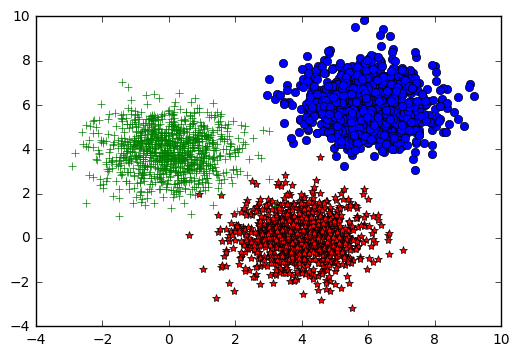

In [5]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

### Initialization

Assuming that we know that there are threee components.

In [6]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            cent2.append(cent[i])
        
        
            
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        
        mean = array(cent2[0])
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k)
        
       
        
        #then accumulate the deviations
        cov = zeros((len(mean),len(mean)),dtype=float)
        for x in cent2:
            xmm = array(x) - mean
            for i in range(len(mean)):
                cov[i,i] = cov[i,i] + xmm[i]*xmm[i]
                
        cov = cov/(float(self.options.k))
        covInv = linalg.inv(cov)
        
        cov_1 = [covInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), cent2, cov_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEmInit.run()


Overwriting mr_GMixEmInitialize.py



### Iteration

**Mapper** – each mapper needs k vector means and covariance matrices to make probability calculations. Can also accumulate partial sum (sum restricted to the mapper's input) of quantities required for update. Then it emits partial sum as single output from combiner.
Emit (dummy_key, partial_sum_for_all_k's)

**Reducer** –the iterator pulls in the partial sum for all k's from all the mappers and combines in a single reducer. In this case the reducer emits a single (json'd python object) with the new means and covariances.


In [7]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json


# normal density function
def gauss(x, mu, P_1):
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    sd = sqrt(detP)
    p = p/(pow(2.0*pi,n/2.0)*sd)
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        temp = inputList[0]        
        self.phi = array(temp)           #prior class probabilities
        temp = inputList[1]
        self.means = array(temp)         #current means list
        temp = inputList[2]
        self.cov_1 = array(temp)         #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        
        # --------------- Eq. (1) --------------------------- #
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i])
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        # ----------------------- Eq. (2) ----------------- #
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi est (2.3)
        self.new_phi = self.new_phi + wtVect
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc (2.1)
            self.new_means[i] = self.new_means[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate (2.2)
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc     
        #dummy yield - real output passes to mapper_final in self

        
    def mapper_final(self):
        
        out = [self.count, (self.new_phi).tolist(), (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        #accumulate partial sums
        #xs us a list of paritial stats, including count, prior, mean, and covariance. 
        #Each stats is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPrior = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPrior = totPrior + array(temp[1])
                totMeans = totMeans + array(temp[2])
                totCov = totCov + array(temp[3])
        #finish calculation of new probability parameters. array divided by array
        newPrior = totPrior/totCount
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPrior[i]
            tempCov = totCov[i,:,:]/totPrior[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        outputList = [newPrior.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Overwriting mr_GMixEmIterate.py


### Driver

Iteration0
[[4.591498480526598, -0.6825833544013407], [5.352437581252104, 4.029583730474803], [6.313646595429175, 6.6087388945559375]]


/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


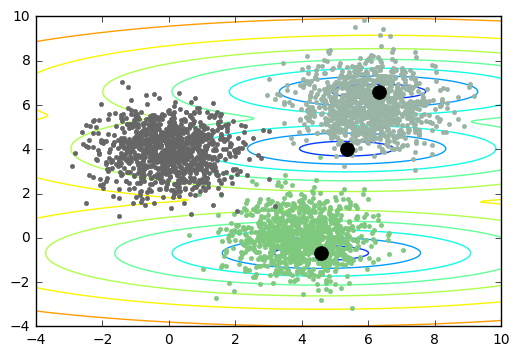

Iteration1
[[1.7998392868952169, 2.21208496196285], [5.190790407014096, 4.391572921590833], [6.502711625955197, 5.941971879421567]]


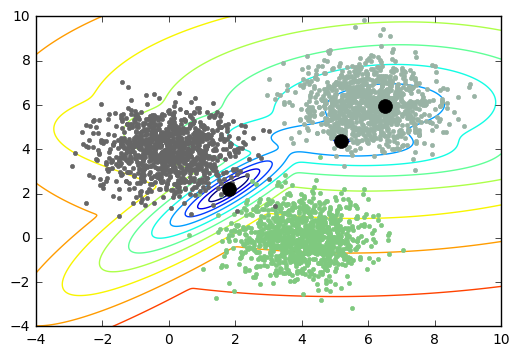

Iteration2
[[1.7795571652948834, 2.1064362054504158], [5.089404868777351, 4.377450445618511], [6.39861517632028, 6.040540401720909]]


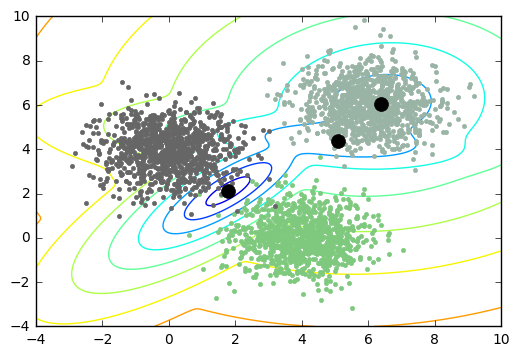

Iteration3
[[1.7806313597145302, 2.1001521947190653], [5.045125366948631, 4.179120775488496], [6.312521774457931, 6.038237199860152]]


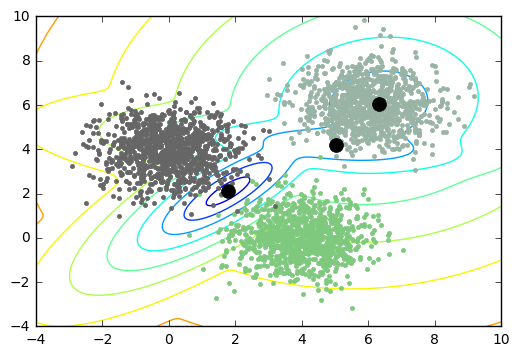

Iteration4
[[1.7750486532601446, 2.1067849220948953], [5.01353230655937, 3.8626028852202827], [6.232516094841312, 6.0370865773740165]]


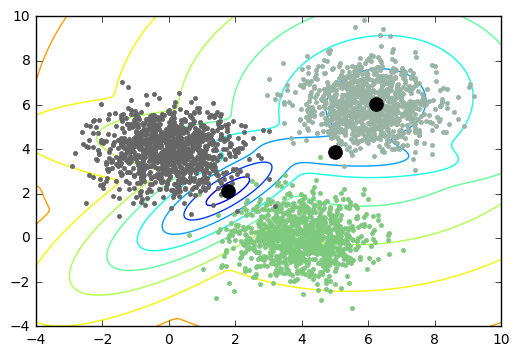

Iteration5
[[1.76469724175202, 2.1191494515403657], [4.98513311395936, 3.4503530502853077], [6.164316674087477, 6.0372465681897545]]


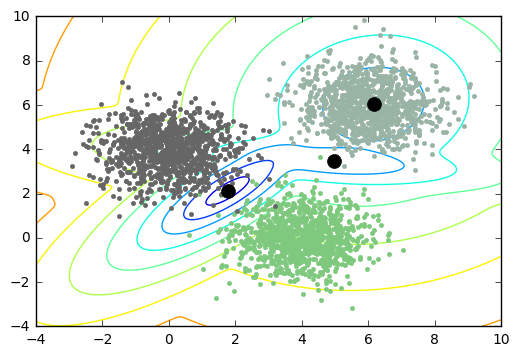

Iteration6
[[1.7521312129276083, 2.1340961573203265], [4.955408162646743, 2.9911610313024717], [6.11174445520522, 6.038044549545318]]


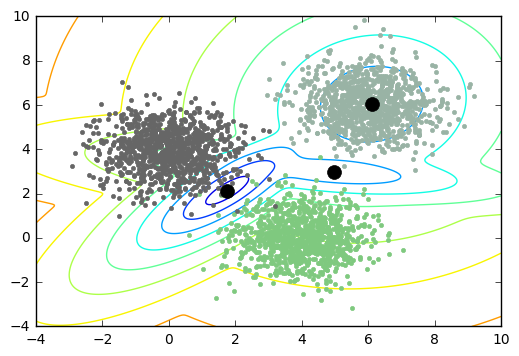

Iteration7
[[1.7391798546254855, 2.149307485618764], [4.922484926644656, 2.5479090827612927], [6.075027428259779, 6.0395449182844745]]


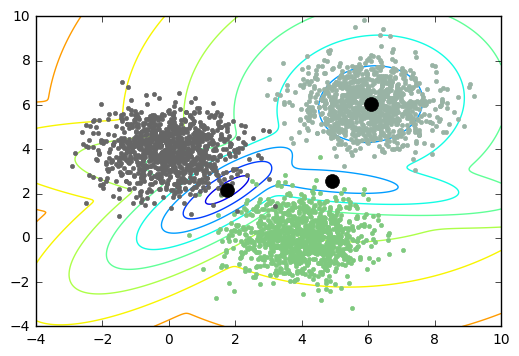

Iteration8
[[1.7256705770534853, 2.1642590488727875], [4.886246994255825, 2.153664047389021], [6.050622402498988, 6.041766851973575]]


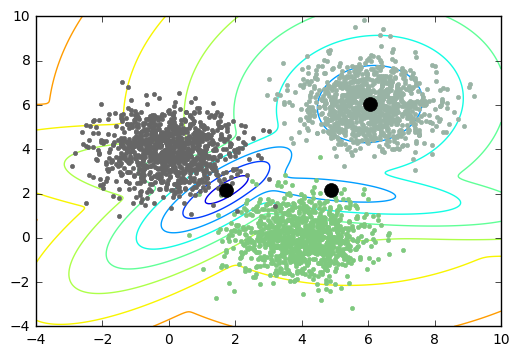

Iteration9
[[1.7101387353420885, 2.1800209070398675], [4.846092464457322, 1.8041900608730277], [6.034302233640605, 6.0443989981870345]]


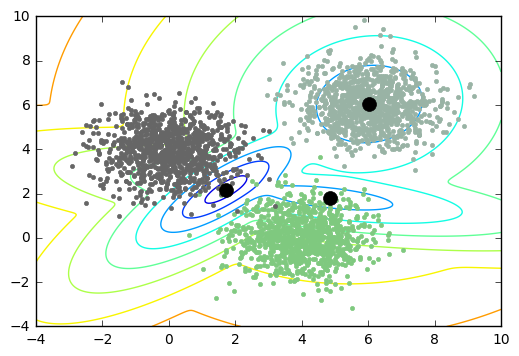

Iteration10
[[1.6907662678685837, 2.1982957251829114], [4.799870561938782, 1.4770917662478904], [6.0229431639808295, 6.0472111659648915]]


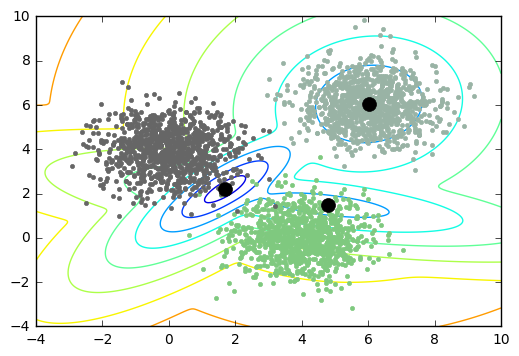

Iteration11
[[1.6650199158986425, 2.2214816744949144], [4.743544910401929, 1.1418653390562619], [6.01441590821145, 6.050249017806374]]


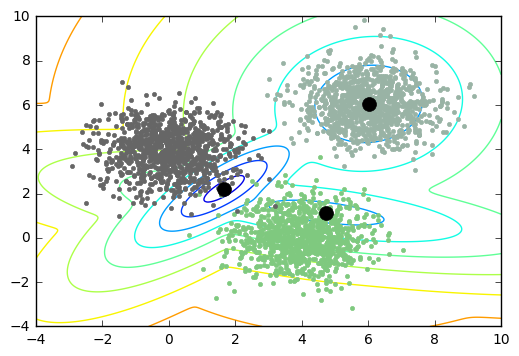

Iteration12
[[1.6277306771355267, 2.2542888328647095], [4.671573831810696, 0.7674283079685231], [6.006937730871093, 6.0524293645746345]]


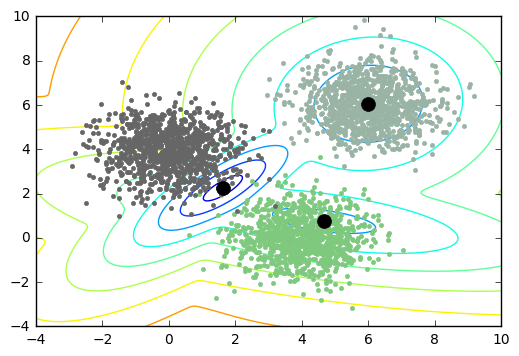

Iteration13
[[1.566566298724747, 2.307944917717138], [4.58473272827266, 0.37751060624343835], [5.998767760388841, 6.045948733611409]]


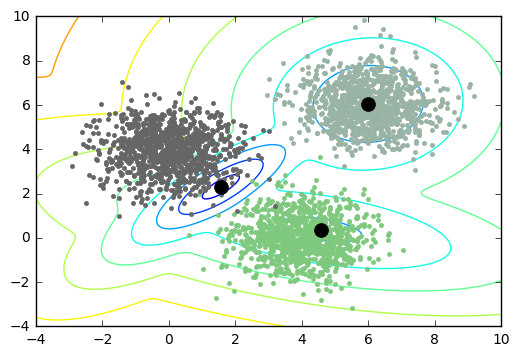

Iteration14
[[1.4605930787371657, 2.4029769032890442], [4.499502960462004, 0.08446666241313508], [5.991015567641017, 6.0282382892475885]]


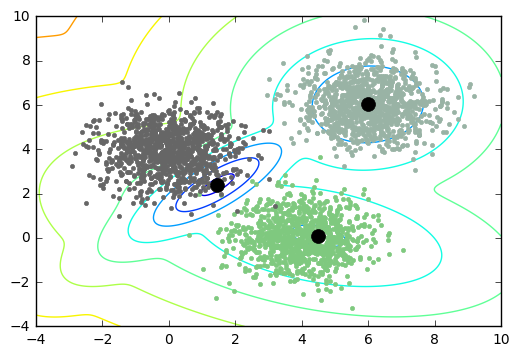

Iteration15
[[1.3016848787495034, 2.5522595155036147], [4.43588741335159, -0.03802726368603912], [5.987398066838339, 6.01673368622941]]


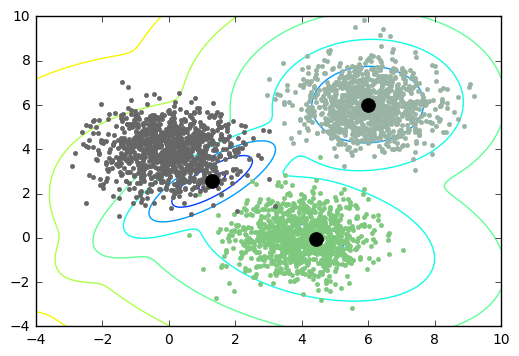

Iteration16
[[1.1295416634694022, 2.72379567296907], [4.380812809896465, -0.08109099927655973], [5.986751123759624, 6.014556267513788]]


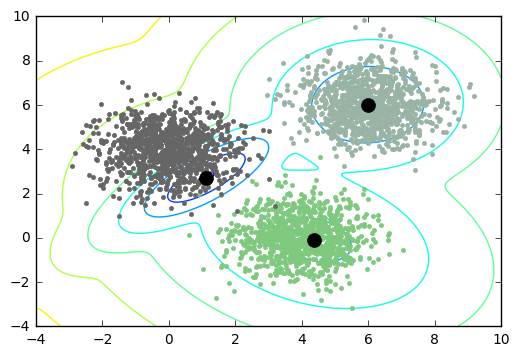

Iteration17
[[0.9645314201103075, 2.8966501748403863], [4.32479570787481, -0.1027617035091027], [5.986805292823223, 6.014259672802755]]


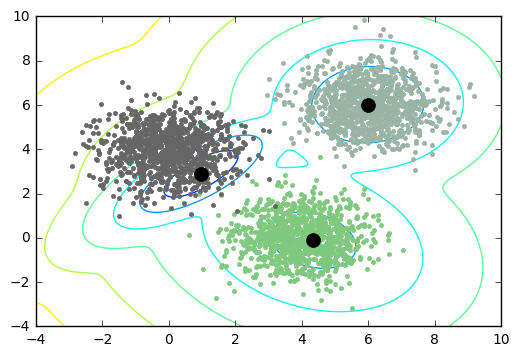

Iteration18
[[0.8001084468697521, 3.074600500020589], [4.270661692333705, -0.11438788231888584], [5.986873473831239, 6.014149151472967]]


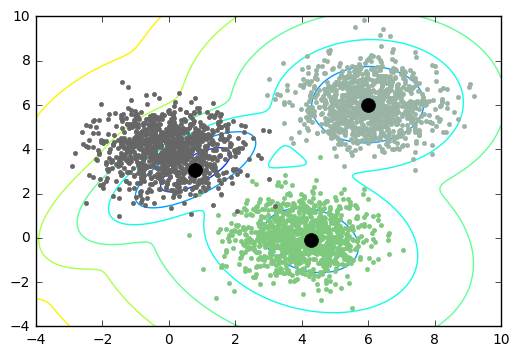

Iteration19
[[0.6287988747336133, 3.2632831458359504], [4.2192653612084206, -0.11856040791243773], [5.986895515469415, 6.0140697906785405]]


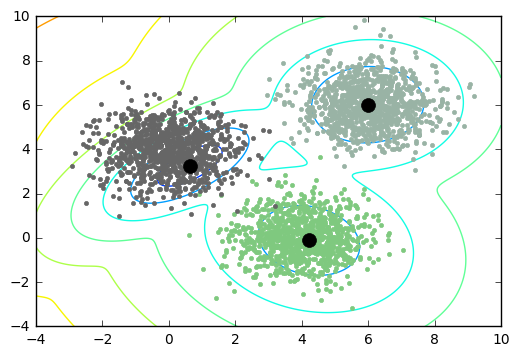

Iteration20
[[0.4501513624511288, 3.4618359749757928], [4.167312896941865, -0.1126520916886571], [5.986887979794902, 6.013994350383207]]


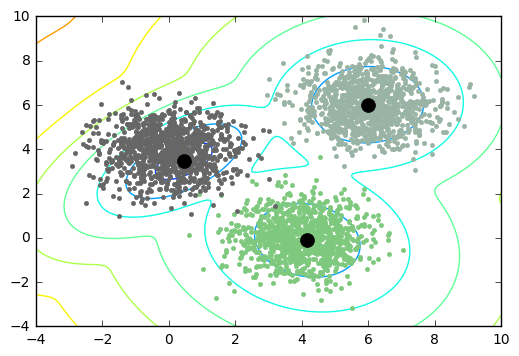

Iteration21
[[0.2739763817255638, 3.6571966696489917], [4.111933786276783, -0.09168938088337339], [5.986868130879954, 6.013905205348927]]


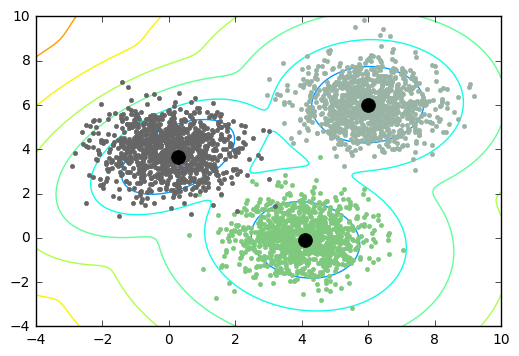

Iteration22
[[0.1256563043074793, 3.8180085751490522], [4.055694623943748, -0.054675662406104934], [5.986808192864244, 6.01376366567671]]


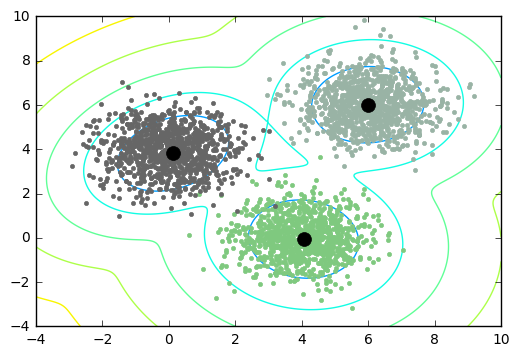

Iteration23
[[0.03445331680656124, 3.9127041773970523], [4.013788067480284, -0.018868161496110574], [5.98657732352711, 6.013524782787201]]


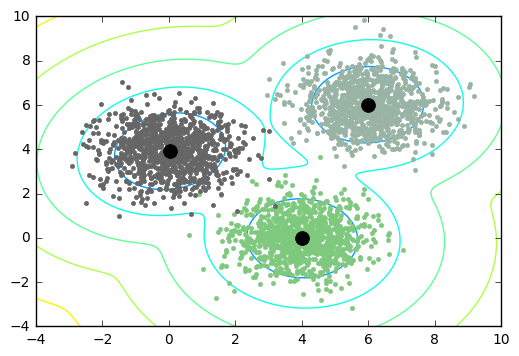

Iteration24
[[4.8738311649654495e-05, 3.945511087207148], [3.9950309424213475, 0.00022025871011633293], [5.9861710970556405, 6.013273790684858]]


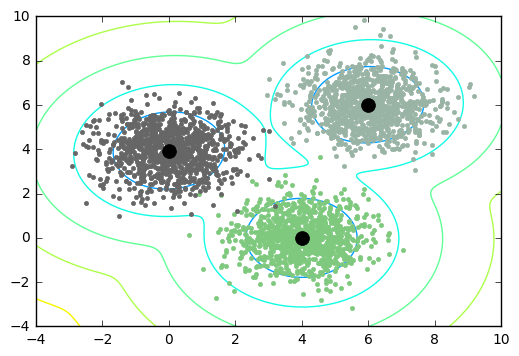

Iteration25
[[-0.00825595824499175, 3.9525455721364002], [3.9898313510470444, 0.006101071326948441], [5.985857456113024, 6.0131492936010265]]


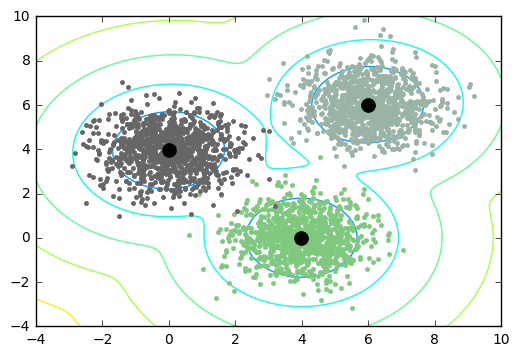

In [11]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal



def log_likelihood(priors,means,covs,grid):
    '''Calculates log-likelihood of Gaussian mixture components.'''
    likelihood = [0]*grid.shape[0]
    for prior,mean,cov in zip(priors,means,covs):
        # From Eq. 1., the log-likelihood is proportional to sum(log(sum(prior*multivariate normal prob)))
        mvn = multivariate_normal(mean=mean, cov=cov)
        mvn_pdf = mvn.pdf(grid)
        # cannot take the log here!!! See http://www.cs.ubbcluj.ro/~csatol/gep_tan/Bishop-CUED-2006.pdf, slide 41
        likelihood += prior*mvn_pdf
    return np.log(likelihood)



def plot_iteration(priors,means,covs,X,Y,surface_type = 'aggregate'):
    colors = plt.cm.Accent(np.linspace(1e-8,1,3))
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = colors[0])
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = colors[1])
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = colors[2])
    pylab.plot(means[0][0], means[0][1],'o',markersize =10,color = 'black')
    pylab.plot(means[1][0], means[1][1],'o',markersize =10,color = 'black')
    pylab.plot(means[2][0], means[2][1],'o',markersize =10,color = 'black')
    grid = np.array([X.ravel(), Y.ravel()]).T
    if surface_type == 'individual':
        for i in range(3):
            Z = -log_likelihood(priors[i:(i+1)],means[i:(i+1)],covs[i:(i+1)],grid)
            Z_shape = (np.sqrt(len(Z)),np.sqrt(len(Z)))
            Z = Z.reshape(Z_shape)
            plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=200.0),levels=np.logspace(0, 3, 6))
    elif surface_type == 'aggregate':
        Z = -log_likelihood(priors,means,covs,grid)
        Z_shape = (np.sqrt(len(Z)),np.sqrt(len(Z)))
        Z = Z.reshape(Z_shape)
        plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=200.0),levels=np.logspace(0, 3, 15))
    else:
        raise ValueError("Set surface_type either 'aggregate' or 'individual'")
    pylab.show()


def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath,'--pathName=/home/cloudera/W261/Spring2017/HW6/'])
with mrJob.make_runner() as runner:
    runner.run()
    
    
    
#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

# set plotting grid
x = np.linspace(-4.0,10.0,300)
y = np.linspace(-4.0,10.0,300)
X,Y = np.meshgrid(x,y)


delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldPriors = oldParam[0]
    oldMeans = oldParam[1]
    oldCovs = oldParam[2]
    mrJob2 = MrGMixEm(args=[filePath,'--pathName=/home/cloudera/W261/Spring2017/HW6/'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newPriors = newParam[0]
    newMeans = newParam[1]
    newCovs = newParam[2]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
    plot_iteration(oldPriors,oldMeans,oldCovs,X,Y)
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newPriors,newMeans,newCovs,X,Y)
